In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import random
import string
import tensorflow as tf
from tensorflow.python.ops.rnn_cell import _linear
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import collections
import matplotlib.pyplot as plt
import codecs
import time
import os
import gc
from six.moves import cPickle as pickle

from plot_module import text_plot
from plot_module import structure_vocabulary_plots

from model_module import maybe_download
from model_module import read_data
from model_module import check_not_one_byte
from model_module import BatchGenerator
from model_module import logprob
from model_module import sample_distribution

In [6]:
url = 'http://mattmahoney.net/dc/'


def maybe_download(filename, expected_bytes):
  #Download a file if not present, and make sure it's the right size.
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

def read_data(filename):
    if not os.path.exists('enwik8'):
        f = zipfile.ZipFile(filename)
        for name in f.namelist():
            full_text = tf.compat.as_str(f.read(name))
        f.close()
        """f = open('enwik8', 'w')
        f.write(text.encode('utf8'))
        f.close()"""
    else:
        f = open('enwik8', 'r')
        full_text = f.read().decode('utf8')
        f.close()
    return full_text
        
    f = codecs.open('enwik8', encoding='utf-8')
    text = f.read()
    f.close()
    return text

def check_not_one_byte(text):
    not_one_byte_counter = 0
    max_character_order_index = 0
    min_character_order_index = 2**16 
    present_characters = [0]*256
    number_of_characters = 0
    for i in range(len(text)):
        if ord(text[i]) > 255:
            not_one_byte_counter += 1 
        if len(present_characters) <  ord(text[i]):
            present_characters.extend([0]*(ord(text[i]) - len(present_characters) + 1))
            present_characters[ord(text[i])] = 1
            number_of_characters += 1
        elif present_characters[ord(text[i])] == 0:
            present_characters[ord(text[i])] = 1
            number_of_characters += 1
        if ord(text[i]) > max_character_order_index:
            max_character_order_index = ord(text[i])
        if ord(text[i]) < min_character_order_index:
            min_character_order_index = ord(text[i])
    return not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters

if not os.path.exists('enwik8_filtered'):
    if not os.path.exists('enwik8'):
        filename = maybe_download('enwik8.zip', 36445475)
    full_text = read_data(filename)
    new_text = u""
    new_text_list = list()
    for i in range(len(full_text)):
        if (i+1) % 10000000 == 0:
            print("%s characters are filtered" % i)
        if ord(full_text[i]) < 256:
            new_text_list.append(full_text[i])
    text = new_text.join(new_text_list)
    del new_text_list
    del new_text
    del full_text

    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)
    
    f = open('enwik8_filtered', 'w')
    f.write(text.encode('utf8'))
    f.close()
    
else:
    f = open('enwik8_filtered', 'r')
    text = f.read().decode('utf8')
    f.close() 
    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)    

number of not one byte characters:  0
min order index:  9
max order index:  255
total number of characters:  196


In [7]:
#different
offset = 20000
valid_size = 10000
valid_text = text[offset:offset+valid_size]
train_text = text[offset+valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99350000 n in the February 1934 riots, anarchists divided over a 'united 
10000 ture in Mutual Aid: A Factor of Evolution (1897). Subsequent ana


In [8]:
vocabulary_size = number_of_characters
vocabulary = list()
characters_positions_in_vocabulary = list()

character_position_in_vocabulary = 0
for i in range(256):
    if present_characters_indices[i]:
        vocabulary.append(unichr(i))
        characters_positions_in_vocabulary.append(character_position_in_vocabulary)
        character_position_in_vocabulary += 1
    else:
        characters_positions_in_vocabulary.append(-1)

def char2id(char, characters_positions_in_vocabulary):
  if characters_positions_in_vocabulary[ord(char)] != -1:
    return characters_positions_in_vocabulary[ord(char)]
  else:
    print(u'Unexpected character: %s\nUnexpected character number: %s\nUnexpected character has its place = %s\n' % (char, ord(char), present_characters_indices[i]))
    return characters_positions_in_vocabulary[ord(char)]
  
def id2char(dictid, vocabulary):
  voc_size = len(vocabulary)
  if (dictid >= 0) and (dictid < voc_size):
    return vocabulary[dictid]
  else:
    print(u"unexpected id")
    return u'\0'

string_vocabulary = u""
for i in range(vocabulary_size):
    string_vocabulary += vocabulary[i]
print("Vocabulary: ", string_vocabulary)
print("char2id(u'a') = %s,  char2id(u'z') = %s,  char2id(u' ') = %s" % (char2id(u'a', characters_positions_in_vocabulary),
                                                                        char2id(u'z', characters_positions_in_vocabulary),
                                                                        char2id(u' ', characters_positions_in_vocabulary)))
print("id2char(78) = %s,  id2char(156) = %s,  id2char(140) = %s" % (id2char(78,
                                                                            vocabulary),
                                                                    id2char(156,
                                                                            vocabulary),
                                                                    id2char(140,
                                                                            vocabulary)))


Vocabulary:  	
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¡¢£¤¥¦§¨©ª«¬­®¯°±²³´µ¶·¸¹º»¼½¾¿ÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖ×ØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿ
char2id(u'a') = 67,  char2id(u'z') = 92,  char2id(u' ') = 2
id2char(78) = l,  id2char(156) = Ø,  id2char(140) = È


In [9]:
batch_size_test=64
num_unrollings_test=10

class BatchGenerator(object):
  def __init__(self, text, batch_size, vocabulary_size, characters_positions_in_vocabulary, num_unrollings):
    self._text = text
    self._text_size = len(text)
    self._batch_size = batch_size
    self._vocabulary_size = vocabulary_size
    self._characters_positions_in_vocabulary = characters_positions_in_vocabulary
    self._num_unrollings = num_unrollings
    segment = self._text_size // batch_size
    self._cursor = [ offset * segment for offset in range(batch_size)]
    self._last_batch = self._next_batch()
  
  def _next_batch(self):
    """Generate a single batch from the current cursor position in the data."""
    batch = np.zeros(shape=(self._batch_size, self._vocabulary_size), dtype=np.float)
    for b in range(self._batch_size):
      batch[b, char2id(self._text[self._cursor[b]], self._characters_positions_in_vocabulary)] = 1.0
      self._cursor[b] = (self._cursor[b] + 1) % self._text_size
    return batch
  
  def next(self):
    """Generate the next array of batches from the data. The array consists of
    the last batch of the previous array, followed by num_unrollings new ones.
    """
    batches = [self._last_batch]
    for step in range(self._num_unrollings):
      batches.append(self._next_batch())
    self._last_batch = batches[-1]
    return batches

def characters(probabilities, vocabulary):
  """Turn a 1-hot encoding or a probability distribution over the possible
  characters back into its (most likely) character representation."""
  return [id2char(c, vocabulary) for c in np.argmax(probabilities, 1)]

def batches2string(batches, vocabulary):
  """Convert a sequence of batches back into their (most likely) string
  representation."""
  s = [u""] * batches[0].shape[0]
  for b in batches:
    s = [u"".join(x) for x in zip(s, characters(b, vocabulary))]
  return s

train_batches_test = BatchGenerator(train_text,
                                    batch_size_test,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    num_unrollings_test)
valid_batches_test = BatchGenerator(valid_text,
                                    1,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    1)

print(batches2string(train_batches_test.next(), vocabulary))
print(batches2string(train_batches_test.next(), vocabulary))
print(batches2string(valid_batches_test.next(), vocabulary))
print(batches2string(valid_batches_test.next(), vocabulary))

[u'n in the Fe', u".\n* ''[[Con", u"oldier's so", u'\xf6hm-Bawerk ', u'tification,', u' warrior, a', u'uot; would ', u' 115       ', u'orbata acid', u'>\n      <co', u'ate, the co', u'other natio', u'ing the his', u'et bromine;', u' Christ&quo', u' average]] ', u' their home', u'ks and a ri', u'on]]/[[Joel', u' new era fo', u'aph that th', u' known as t', u's from the ', u'ast majorit', u'trips, thou', u'ent of regi', u'metric aspe', u'd named by ', u'Z</timestam', u'tude of 1 c', u'!&quot; [ht', u'o ==\n\n* [[D', u'[[Belarusia', u'iton]], Rus', u'ccessful si', u'es his theo', u' explain th', u' the South.', u'sing with a', u'd ball is h', u'e could des', u'[Friedrich ', u'th virtuall', u' foreign ac', u'variant in ', u'd and watch', u"t; ''[[Foot", u' became Lea', u'stern Europ', u' </contribu', u'ese terms n', u'arting in t', u'gence of th', u'of the cons', u'uickly swit', u', thus star', u'lly develop', u'g the offic', u'esult, the ', u'red HMMWV. ', u'ament is de', u'University ', 

In [10]:
def logprob(predictions, labels):
  """Log-probability of the true labels in a predicted batch."""
  predictions[predictions < 1e-10] = 1e-10
  return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

def sample_distribution(distribution):
  """Sample one element from a distribution assumed to be an array of normalized
  probabilities.
  """
  r = random.uniform(0, 1)
  s = 0
  for i in range(len(distribution)):
    s += distribution[i]
    if s >= r:
      return i
  return len(distribution) - 1

def sample(prediction, vocabulary_size):
  """Turn a (column) prediction into 1-hot encoded samples."""
  p = np.zeros(shape=[1, vocabulary_size], dtype=np.float)
  p[0, sample_distribution(prediction[0])] = 1.0
  return p

def random_distribution(vocabulary_size):
  """Generate a random column of probabilities."""
  b = np.random.uniform(0.0, 1.0, size=[1, vocabulary_size])
  return b/np.sum(b, 1)[:,None]

def percent_of_correct_predictions(predictions, labels):
    num_characters = predictions.shape[0]
    num_correct = 0
    for i in range(num_characters):
        if labels[i, np.argmax(predictions, axis=1)[i]] == 1:
            num_correct += 1
    return float(num_correct) / num_characters * 100

In [11]:
indices_GL = {"batch_size": 0,
              "num_unrollings": 1,
              "num_layers": 2,
              "num_nodes": 3,
              "half_life": 4,
              "decay": 5,
              "num_steps": 6,
              "averaging_number": 7,
              "type": 8}


class MODEL(object):
    _train_batches = 0
    _valid_batches = 0
    SKIP_LENGTH = 1000
    def __init__(self,
                 batch_size,
                 vocabulary_size,
                 characters_positions_in_vocabulary,
                 num_unrollings,
                 num_layers,
                 num_nodes,
                 train_text,
                 valid_text):
        self._results = list()
        self._batch_size = batch_size
        self._vocabulary = vocabulary
        self._vocabulary_size = len(vocabulary)
        self._characters_positions_in_vocabulary = characters_positions_in_vocabulary
        self._num_unrollings = num_unrollings
        self._num_layers = num_layers
        self._num_nodes = num_nodes
        self._train_text = train_text
        self._valid_text = valid_text
        self._valid_size = len(valid_text)
        self._indices = {"batch_size": 0,
                         "num_unrollings": 1,
                         "num_layers": 2,
                         "num_nodes": 3,
                         "half_life": 4,
                         "decay": 5,
                         "num_steps": 6,
                         "averaging_number": 7,
                         "type": 8}
        self._graph = tf.Graph()
        
        self._last_num_steps = 0
        with self._graph.as_default(): 
            with self._graph.device('/gpu:0'): 
                #list of LSTM cells in multilayered network
                cell_list = list()
                for i in range(self._num_layers):
                    cell_list.append(tf.nn.rnn_cell.BasicLSTMCell(self._num_nodes[i], state_is_tuple=True))
                LSTM = tf.nn.rnn_cell.MultiRNNCell(cell_list, state_is_tuple=True)

                weights_initializer = tf.truncated_normal_initializer(mean=-0.1, stddev=0.1, seed=None, dtype=tf.float32)
                LSTM_scope = 'LSTM'
                with tf.variable_scope(LSTM_scope, reuse=False):
                  for i in range(self._num_layers):
                    with tf.variable_scope("Cell%d" % i):
                      with tf.variable_scope("BasicLSTMCell"):
                        with tf.variable_scope("Linear"):
                          if i == 0:
                            input_dim = self._vocabulary_size + cell_list[i].output_size
                          else:
                            input_dim = cell_list[i-1].output_size + cell_list[i].output_size
                          output_dim = 4*cell_list[i].output_size
                          tf.get_variable("Matrix", [input_dim, output_dim], initializer=weights_initializer)
                          tf.get_variable("Bias", 
                                          initializer=tf.zeros_initializer(shape=[output_dim], dtype=tf.float32))

                # classifier 
                weights = tf.Variable(tf.truncated_normal([LSTM.output_size, self._vocabulary_size], stddev = 0.1))
                bias = tf.Variable(tf.zeros([self._vocabulary_size]))
                
                """PLACEHOLDERS train data"""
                self._train_data = list()
                for _ in range(self._num_unrollings + 1):
                    self._train_data.append(
                        tf.placeholder(tf.float32, shape=[self._batch_size, self._vocabulary_size]))
                train_inputs = self._train_data[: self._num_unrollings]
                train_labels = self._train_data[1:]  # labels are inputs shifted by one time step.
                # Unrolled LSTM loop.

                saved_state = list()
                for i in range(self._num_layers):
                    zero_c, zero_h = cell_list[i].zero_state(self._batch_size, tf.float32)
                    shape_c = zero_c.get_shape().as_list()
                    shape_h = zero_h.get_shape().as_list()
                    saved_state.append((tf.Variable(tf.zeros(shape_c), trainable=False),
                                        tf.Variable(tf.zeros(shape_h), trainable=False)))    #AMENDMENT!!!!

                outputs = list()
                state = saved_state
                for i in train_inputs:
                    with tf.variable_scope('', reuse=True): 
                        output, state = LSTM(i, state, scope=LSTM_scope)
                    outputs.append(output)

                save_list = list()
                for i in range(self._num_layers):
                    save_list.append(saved_state[i][0].assign(state[i][0]))
                    save_list.append(saved_state[i][1].assign(state[i][1]))
                
                """skip operation"""
                self._skip_operation = tf.group(*save_list)

                with tf.control_dependencies(save_list):
                        # Classifier.
                    logits = tf.nn.xw_plus_b(tf.concat(0, outputs), weights, bias)
                    """loss"""
                    self._loss = tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(
                        logits, tf.concat(0, train_labels)))
                # Optimizer.
                self._global_step = tf.Variable(0)
                """PLACEHOLDERS half life and decay"""
                self._half_life = tf.placeholder(tf.int32)
                self._decay = tf.placeholder(tf.float32)
                """learning rate"""
                self._learning_rate = tf.train.exponential_decay(10.0,
                                                                 self._global_step,
                                                                 self._half_life,
                                                                 self._decay,
                                                                 staircase=True)
                optimizer = tf.train.GradientDescentOptimizer(self._learning_rate)
                gradients, v = zip(*optimizer.compute_gradients(self._loss))
                gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
                """optimizer"""
                self._optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=self._global_step)
                """train prediction"""
                self._train_prediction = tf.nn.softmax(logits)

                # Sampling and validation eval: batch 1, no unrolling.
                saved_sample_state = list()

                for i in range(self._num_layers):
                    sample_zero_c, sample_zero_h = cell_list[i].zero_state(1, tf.float32)
                    sample_shape_c = sample_zero_c.get_shape().as_list()
                    sample_shape_h = sample_zero_h.get_shape().as_list()
                    saved_sample_state.append((tf.Variable(tf.zeros(sample_shape_c)), tf.Variable(tf.zeros(sample_shape_h))))  
                """PLACEHOLDER sample input"""
                self._sample_input = tf.placeholder(tf.float32, shape=[1, self._vocabulary_size])

                reset_list = list()
                for i in range(self._num_layers):
                    sample_zero_c, sample_zero_h = cell_list[i].zero_state(1, tf.float32)
                    sample_shape_c = sample_zero_c.get_shape().as_list()
                    sample_shape_h = sample_zero_h.get_shape().as_list()
                    reset_list.append(saved_sample_state[i][0].assign(tf.zeros(sample_shape_c)))
                    reset_list.append(saved_sample_state[i][1].assign(tf.zeros(sample_shape_h)))
                """reste sample state"""
                self._reset_sample_state = tf.group(*reset_list)

                with tf.variable_scope('', reuse=True): 
                    sample_output, sample_state = LSTM(self._sample_input, saved_sample_state, scope=LSTM_scope)

                sample_save_list = list()
                for i in range(self._num_layers):
                    sample_save_list.append(saved_sample_state[i][0].assign(sample_state[i][0]))
                    sample_save_list.append(saved_sample_state[i][1].assign(sample_state[i][1]))    

                with tf.control_dependencies(sample_save_list):
                    """sample prediction"""
                    self._sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, weights, bias)) 
                
                Matrices = list()
                Biases = list()
                gates = list()
                with tf.variable_scope(LSTM_scope, reuse=True):
                    for i in range(self._num_layers):
                        with tf.variable_scope("Cell%d" % i):
                            with tf.variable_scope("BasicLSTMCell/Linear"):
                                Matrices.append(tf.get_variable("Matrix"))
                                Biases.append(tf.get_variable("Bias"))
                cur_inp = self._sample_input
                for layer_num in range(self._num_layers):
                    concat = tf.matmul(tf.concat(1, [cur_inp,
                                                     saved_sample_state[layer_num][1]]),
                                       Matrices[layer_num]) + Biases[layer_num]
                    i, _, f, o = tf.split(1, 4, concat)
                    gates.append(tf.concat(0,
                                           [tf.sigmoid(i),
                                            tf.sigmoid(f),
                                            tf.sigmoid(o)]))
                    with tf.variable_scope(LSTM_scope, reuse=True):
                        with tf.variable_scope("Cell%d" % layer_num):
                            cur_inp, _ = cell_list[layer_num](cur_inp, saved_sample_state[layer_num])
                    
                """gates"""
                # important changes were made
                self.gates = tf.concat(1, gates)
                
                """saver"""
                self.saver = tf.train.Saver(max_to_keep=None)
                            
                        
                    
    def learn(self,
              session,
              min_num_steps,
              loss_frequency, # loss is calculated with frequency loss_frequency
              block_of_steps, #learning has a chance to be stopped after every block of steps
              num_stairs,
              decay,
              stop_percent,
              optional_feed_dict=None,
              half_life_fixed=False):
        if not half_life_fixed and (self._last_num_steps > min_num_steps):
            min_num_steps = self._last_num_steps
        half_life = min_num_steps / num_stairs
            
            
        if self._train_batches == 0:
            self._train_batches = BatchGenerator(self._train_text,
                                                 self._batch_size,
                                                 self._vocabulary_size,
                                                 self._characters_positions_in_vocabulary,
                                                 self._num_unrollings)
            
        losses = [0.]

        tf.initialize_all_variables().run()
        start_time = time.clock()
        mean_loss = 0.
        step = 0
        while not ((step - 1) % block_of_steps == 0 and
                   (losses[len(losses) / 2] - losses[-1]) < losses[len(losses) / 2] * stop_percent / 100 and
                   step >= min_num_steps):
            batches = self._train_batches.next()
            feed_dict = {self._half_life: half_life, self._decay: decay}
            if optional_feed_dict is not None:
                new_dict = dict()
                for optional_key in optional_feed_dict.keys():
                    exec("new_dict[%s] = %s" % (optional_key, optional_feed_dict[optional_key]))
                feed_dict.update(new_dict)
            for i in range(self._num_unrollings + 1):
                feed_dict[self._train_data[i]] = batches[i]
            _, l = session.run([self._optimizer,
                                self._loss],
                               feed_dict=feed_dict)
            mean_loss += l              
            if step % loss_frequency == 0:
                if step > 0:
                    mean_loss = mean_loss / loss_frequency
                    # The mean loss is an estimate of the loss over the last few batches.
                losses.append(mean_loss)
                mean_loss = 0
            step += 1
        finish_time = time.clock() 
        self._last_num_steps = step
        return finish_time - start_time
        
    def calculate_percentages(self,
                              session,
                              num_averaging_iterations):
        
        data_for_plot = {'train': {'step': list(), 'percentage': list()},
                         'validation': {'step': list(), 'percentage': list()}}
        
        data_for_plot['train']['step'].append(-1)
        data_for_plot['validation']['step'].append(-1)
        
        if self._valid_batches == 0:
            self._valid_batches = BatchGenerator(self._valid_text,
                                                 1,
                                                 self._vocabulary_size,
                                                 self._characters_positions_in_vocabulary,
                                                 1)
        
        average_percentage_of_correct = 0.
        for i in range(num_averaging_iterations):
            for j in range(self.SKIP_LENGTH / self._num_unrollings):
                batches = self._train_batches.next()
                feed_dict = dict()
                for i in range(self._num_unrollings + 1):
                    feed_dict[self._train_data[i]] = batches[i]
                session.run(self._skip_operation, feed_dict=feed_dict)
            batches = self._train_batches.next()
            feed_dict = dict()
            for i in range(self._num_unrollings + 1):
                feed_dict[self._train_data[i]] = batches[i]            
            predictions = session.run(self._train_prediction, feed_dict=feed_dict)
            labels = np.concatenate(list(batches)[1:])
            average_percentage_of_correct += percent_of_correct_predictions(predictions, labels) 
        average_percentage_of_correct /= num_averaging_iterations
        
        self._reset_sample_state.run()
        validation_percentage_of_correct = 0.
        for _ in range(self._valid_size):
            b = self._valid_batches.next()
            predictions = self._sample_prediction.eval({self._sample_input: b[0]})
            validation_percentage_of_correct += percent_of_correct_predictions(predictions, b[1])
        validation_percentage_of_correct /= self._valid_size
        
        
        data_for_plot['train']['percentage'].append(average_percentage_of_correct)
        data_for_plot['validation']['percentage'].append(validation_percentage_of_correct)
        return data_for_plot
    
    def _generate_metadata(self, half_life, decay, num_averaging_iterations):
        metadata = list()
        metadata.append(self._batch_size)
        metadata.append(self._num_unrollings)
        metadata.append(self._num_layers)
        metadata.append(self._num_nodes)
        metadata.append(half_life)
        metadata.append(decay)
        metadata.append(self._last_num_steps)
        metadata.append(num_averaging_iterations)
        metadata.append('simple')
        return metadata
        
    def simple_run(self,
                   num_averaging_iterations,
                   save_path,
                   min_num_steps,
                   loss_frequency,
                   block_of_steps,        #learning has a chance to be stopped after every block of steps
                   num_stairs,
                   decay,
                   stop_percent,
                   optional_feed_dict=None,
                   half_life_fixed=False):
        config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)
        
        if not half_life_fixed and (self._last_num_steps > min_num_steps):
            min_num_steps = self._last_num_steps
        half_life = min_num_steps / num_stairs 
        
        with tf.Session(graph=self._graph, config=config) as session:
            learn_time = self.learn(session,
                                    min_num_steps,
                                    loss_frequency,
                                    block_of_steps,
                                    num_stairs,
                                    decay,
                                    stop_percent,
                                    optional_feed_dict=optional_feed_dict,
                                    half_life_fixed=half_life_fixed)
            data_for_plot = self.calculate_percentages(session, num_averaging_iterations)
            if self._last_num_steps == 0:
                GLOBAL_STEP = min_num_steps
            else:
                GLOBAL_STEP = self._last_num_steps
            lr = self._learning_rate.eval(feed_dict={self._global_step: GLOBAL_STEP,
                                                     self._half_life: half_life,
                                                     self._decay: decay},
                                          session=session)  
            
            if save_path is not None:
                folder_list = save_path.split('/')[:-1]
                if len(folder_list) > 0:
                    current_folder = folder_list[0]
                    for idx, folder in enumerate(folder_list):
                        if idx > 0:
                            current_folder += ('/' + folder)
                        if not os.path.exists(current_folder):
                            os.mkdir(current_folder)


                self.saver.save(session, save_path)
        
        run_result = {"metadata": list(), "data": data_for_plot, "time": learn_time}
        if optional_feed_dict is None:
            run_result["metadata"] = self._generate_metadata(half_life,
                                                             decay,
                                                             num_averaging_iterations)
        else:
            run_result["metadata"] = self._generate_metadata(half_life,
                                                             decay,
                                                             num_averaging_iterations,
                                                             *optional_feed_dict.values())            
        self._results.append(run_result)
        
        print("Number of steps = %s     Percentage = %.2f%%     Time = %.fs     Leraning rate = %.2f" % 
              (run_result["metadata"][self._indices["num_steps"]],
              run_result["data"]["train"]["percentage"][-1],
              run_result["time"],
              lr))
        
        
    def run(self,
            num_stairs,
            decay,
            train_frequency,
            min_num_points,
            stop_percent,
            num_train_points_per_1_validation_point,
            averaging_number,
            optional_feed_dict=None,
            print_intermediate_results=False,
            half_life_fixed=False):
        
        if not half_life_fixed and (self._last_num_steps > min_num_points * train_frequency):
            min_num_steps = self._last_num_steps
        else:
            min_num_steps = min_num_points * train_frequency
        half_life = min_num_steps / num_stairs
        
        data_for_plot = {'train': {'step': list(), 'percentage': list()},
                         'validation': {'step': list(), 'percentage': list()}}
        
        if self._train_batches == 0:
            self._train_batches = BatchGenerator(self._train_text,
                                                 self._batch_size,
                                                 self._vocabulary_size,
                                                 self._characters_positions_in_vocabulary,
                                                 self._num_unrollings)
        if self._valid_batches == 0:
            self._valid_batches = BatchGenerator(self._valid_text,
                                                 1,
                                                 self._vocabulary_size,
                                                 self._characters_positions_in_vocabulary,
                                                 1)
        
        averaging_number = min(averaging_number, train_frequency)
        averaging_step = max(train_frequency/averaging_number, 1)
        average_summing_started = False
        
        losses = [0.]

        config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)
        with tf.Session(graph=self._graph, config=config) as session:
            tf.initialize_all_variables().run()
            if print_intermediate_results:
                print('Initialized')
            start_time = time.clock()
            average_percentage_of_correct = 0.
            mean_loss = 0
            step = 0
            while not ((step - 1) % 10000 == 0 and
                       (losses[len(losses) / 2] - losses[-1]) < losses[len(losses) / 2] * stop_percent / 100 and
                       (len(losses) - 1) >= min_num_points / num_train_points_per_1_validation_point):
                batches = self._train_batches.next()
                feed_dict = {self._half_life: half_life, self._decay: decay}
                for i in range(self._num_unrollings + 1):
                    feed_dict[self._train_data[i]] = batches[i]
                if optional_feed_dict is not None:
                    new_dict = dict()
                    for optional_key in optional_feed_dict.keys():
                        exec("new_dict[%s] = %s" % (optional_key, optional_feed_dict[optional_key]))
                    feed_dict.update(new_dict)
                _, l, predictions, lr = session.run([self._optimizer,
                                                     self._loss,
                                                     self._train_prediction,
                                                     self._learning_rate],
                                                     feed_dict=feed_dict)
                mean_loss += l
                if ((step - (step / train_frequency) * train_frequency) % averaging_step == 0) and average_summing_started:
                    labels = np.concatenate(list(batches)[1:])
                    average_percentage_of_correct += percent_of_correct_predictions(predictions, labels)
                average_summing_started = True
                
                if step % train_frequency == 0:
                    if step > 0:
                        average_percentage_of_correct /= averaging_number
                        data_for_plot['train']['step'].append(step)
                        data_for_plot['train']['percentage'].append(average_percentage_of_correct)
                    if step % (train_frequency * num_train_points_per_1_validation_point) == 0:
                        if step > 0:
                            mean_loss = mean_loss / (train_frequency * num_train_points_per_1_validation_point)
                            # The mean loss is an estimate of the loss over the last few batches.

                            losses.append(mean_loss)
                        
                        if print_intermediate_results:
                            print('Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
                            print('Percentage_of correct: %.2f%%' % average_percentage_of_correct)
                            if step % (train_frequency * num_train_points_per_1_validation_point * 10) == 0:
                                # Generate some samples.
                                print('=' * 80)
                                for _ in range(5):
                                    feed = sample(random_distribution(self._vocabulary_size), self._vocabulary_size)
                                    sentence = characters(feed, self._vocabulary)[0]
                                    self._reset_sample_state.run()
                                    for _ in range(79):
                                        prediction = self._sample_prediction.eval({self._sample_input: feed})
                                        feed = sample(prediction, self._vocabulary_size)
                                        sentence += characters(feed, self._vocabulary)[0]
                                    print(sentence)
                                print('=' * 80)
                                
                        mean_loss = 0
                        # Measure validation set perplexity.
                        self._reset_sample_state.run()
                        validation_percentage_of_correct = 0.
                        for _ in range(self._valid_size):
                            b = self._valid_batches.next()
                            predictions = self._sample_prediction.eval({self._sample_input: b[0]})
                            validation_percentage_of_correct += percent_of_correct_predictions(predictions, b[1])
                        validation_percentage_of_correct /= self._valid_size
                        if print_intermediate_results:
                            print('Validation percentage of correct: %.2f%%\n' % validation_percentage_of_correct)
                        data_for_plot['validation']['step'].append(step)
                        data_for_plot['validation']['percentage'].append(validation_percentage_of_correct)
                    average_percentage_of_correct = 0.
                    average_summing_started = False
                step += 1
            finish_time = time.clock()
        self._last_num_steps = step
        run_result = {"metadata": list(), "data": data_for_plot, "time": (finish_time - start_time)}
        if optional_feed_dict is None:
            run_result["metadata"] = self._generate_metadata(half_life,
                                                             decay,
                                                             averaging_number)
        else:
            run_result["metadata"] = self._generate_metadata(half_life,
                                                             decay,
                                                             averaging_number,
                                                             *optional_feed_dict.values()) 
        self._results.append(run_result)

        
        if len(data_for_plot['train']['percentage']) < min_num_points:
            print("ERROR! failed to get enough data points")
        else:
            print("Number of steps = %s     Percentage = %.2f%%     Time = %.fs     Leraning rate = %.2f" % 
                  (step,
                   sum(data_for_plot["train"]["percentage"][-1: -1 - min_num_points / 5: -1]) / (min_num_points / 5),
                   run_result["time"],
                   lr))
        
    def plot(self, results_numbers, plot_validation=False, save=False, save_folder=None):
        plt.close()
        colors = {0: 'magenta',
                  1: 'cyan',
                  2: 'yellow',
                  3: 'firebrick',
                  4: 'blue',
                  5: 'gray',
                  6: 'm',
                  7: 'green',
                  8: 'darkgoldenrod',
                  9: 'purple',
                  10: 'k',
                  11: 'r',
                  12: '#E24A33',
                  13: '#92C6FF', 
                  14: '#0072B2',
                  15: '#30a2da',
                  16: '#4C72B0',
                  17: '#8EBA42',
                  18: '#6d904f'}
        fig = plt.figure(1)
        for i in range(len(results_numbers)):
            x_list = self._results[results_numbers[i]]["data"]['train']['step']
            y_list = self._results[results_numbers[i]]["data"]['train']['percentage']
            plt.plot(x_list, y_list, colors[i % 19])
            if plot_validation:
                x_list = self._results[results_numbers[i]]["data"]['validation']['step']
                y_list = self._results[results_numbers[i]]["data"]['validation']['percentage']
                plt.plot(x_list, y_list, color=colors[i], linestyle='dashed')
        num_layers_string = self._results[results_numbers[i]]["metadata"][self._indices["num_layers"]]
        num_unrollings_string = self._results[results_numbers[i]]["metadata"][self._indices["num_unrollings"]]
        plt.title('Number of layers = %s; Number of unrollings = %s' % (num_layers_string,
                                                                        num_unrollings_string))
        

        plt.xlabel('step')
        plt.ylabel('percentage of correct')
        x1, x2, y1, y2 = plt.axis()
        
        text_labels = list()
        for i in range(len(results_numbers)):
            text_label = ""
            text_label += ("time = %.fs;" % self._results[results_numbers[i]]["time"])
            text_label += (" half life = %s;" % self._results[results_numbers[i]]["metadata"][self._indices["half_life"]])
            text_label += (" decay = %.1f;" % self._results[results_numbers[i]]["metadata"][self._indices["decay"]])
            text_labels.append(text_label)
        
        help_text = list()
        for i in range(len(text_labels)):
            vertical_position = y2 - float(y2 - y1) / (len(text_labels) + 1) * float(i+1)
            help_text.append(plt.text(x2 + 0.05 * (x2 - x1), vertical_position, text_labels[i],  va = 'center', ha = 'left', color=colors[i]))
        

        plt.show()


        text_right_edge = 0.
        for i in range(len(help_text)):
            if help_text[i].get_window_extent().get_points()[1][0] > text_right_edge:
                text_right_edge = help_text[i].get_window_extent().get_points()[1][0]   
        text_left_edge = help_text[0].get_window_extent().get_points()[0][0] 
        plt.close()
        
        if save:
            fig = plt.figure(1)
            for i in range(len(results_numbers)):
                x_list = self._results[results_numbers[i]]["data"]['train']['step']
                y_list = self._results[results_numbers[i]]["data"]['train']['percentage']
                plt.plot(x_list, y_list, colors[i % 19])
                if plot_validation:
                    x_list = self._results[results_numbers[i]]["data"]['validation']['step']
                    y_list = self._results[results_numbers[i]]["data"]['validation']['percentage']
                    plt.plot(x_list, y_list, color=colors[i], linestyle='dashed')
            plt.xlabel('step')
            plt.ylabel('percentage of correct') 
            num_layers_string = self._results[results_numbers[i]]["metadata"][self._indices["num_layers"]]
            num_unrollings_string = self._results[results_numbers[i]]["metadata"][self._indices["num_unrollings"]]
            plt.title('Number of layers = %s; Number of unrollings = %s' % (num_layers_string,
                                                                            num_unrollings_string))
            for i in range(len(text_labels)):
                vertical_position = y2 - float(y2 - y1) / (len(text_labels) + 1) * float(i+1) 
                plt.text(x2 + 0.05 * (x2 - x1), vertical_position, text_labels[i],  va = 'center', ha = 'left', color=colors[i%18])
                
            coefficient = (2*text_left_edge - text_right_edge) / text_left_edge
            plt.tight_layout(rect=(0, 0, coefficient, 1))
            
            
            nodes_string = "%s"
            if self._num_layers > 1:
                for i in range(self._num_layers - 1):
                    nodes_string += "_%s"
                nodes_string = '(' + nodes_string + ')'
            plot_filename = "nl%s_;nn_%s;nu_%s;bs_%s;emb_%s" % (self._num_layers,
                                                                nodes_string,
                                                                self._num_unrollings,
                                                                self._batch_size,
                                                                False)
            plot_filename = plot_filename % tuple(self._num_nodes)           
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            index = 0
            while os.path.exists(save_folder + '/' + plot_filename + '#' + str(index) + '.png'):
                index += 1
            plt.savefig(save_folder + '/' + plot_filename + '#' + str(index) + '.png')
            plt.close()
        
        
        
    def destroy(self):
        tf.reset_default_graph()
        
    def get_gates(self, session, num_strings=10, length=75, start_positions=None):
        self._reset_sample_state.run()
        self._valid_batches = BatchGenerator(self._valid_text,
                                             1,
                                             self._vocabulary_size,
                                             self._characters_positions_in_vocabulary,
                                             1)
        if start_positions is None:
            start_positions = list()
            if self._valid_size / num_strings < length:
                num_strings = self._valid_size / length
            for i in range(num_strings):
                start_positions.append(i* (self._valid_size / num_strings) + self._valid_size / num_strings / 2)
            while self._valid_size - start_positions[-1] < length:
                del start_positions[-1]
        text_list = list()
        gate_list = list()
        collect_gates = False
        letters_parsed = -1
        for idx in range(self._valid_size):
            b = self._valid_batches.next()
            
            if idx in start_positions or collect_gates: 
                if letters_parsed == -1:
                    letters_parsed = 0
                    text = u""
                    g_list = list()
                    collect_gates = True
                text += characters(b[0], self._vocabulary)[0]
                g_list.append(self.gates.eval({self._sample_input: b[0]}))
                letters_parsed += 1
                if letters_parsed >= length:
                    collect_gates = False
                    gate_list.append(g_list)
                    text_list.append(text)
                    letters_parsed = -1
                    
            _ = self._sample_prediction.eval({self._sample_input: b[0]})
        return text_list, gate_list  
    
    def run_for_analitics(self,
                          analitics_function,
                          save_path,
                          *args): # analitics arguments, learning arguments
        """learning arguments and analitic arguments are lists of
        arguments passed to learn and analitic_function methods except for 'session'"""
        config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)

        with tf.Session(graph=self._graph, config=config) as session:
            if save_path is None:
                learn_time = self.learn(session, *args[1])
            else:
                self.saver.restore(session, save_path)
            text_list, gate_list = analitics_function(session, *args[0])
        return text_list, gate_list       

In [14]:
model1 = MODEL(64,
               vocabulary,
               characters_positions_in_vocabulary,
               10,
               1,
               [16],
               train_text, valid_text)

In [16]:
model1.simple_run(20,
                   None,
                   10000,
                   200,
                   5000,        #learning has a chance to be stopped after every block of steps
                   20,
                   0.9,
                   3,
                   optional_feed_dict=None,
                   half_life_fixed=False)

Number of steps = 10001     Percentage = 37.91%     Time = 116s     Leraning rate = 1.22


In [17]:
model1.run(20,
            0.9,
            200,
            50,
            3,
            5,
            20,
            print_intermediate_results = True,
            half_life_fixed = False)

Initialized
Average loss at step 0: 5.278673 learning rate: 10.000000
Percentage_of correct: 0.00%
Ó1¯ Äº=¹]1¾¹ 1ÒÿCn:MÅúw^ÉHqkEeàÈo$«ÉÄ±¯¥QUNð Æ)vöÏÁh`:¶ð{7Àå'páf]_b °Ü½hþ]Ò·i@3"
ð7ÛDVdrâ¢rÔdßÚ,l`Æfj:w	 8a¦PyÓ¡3ïÚÝPÃ&Ë{ ù=¥ÙG})¸KÖgÐ«"õÆ®Y:7%öÄeÀÞÐeæK³Â¥	Í1e7­
ib\":¹©áDoBwk/ZWÔúf¸_ÍÜHÒì[Dt7]P°_JiÔ óuØ¥j8ÚM>Î_ec4à(àBt3IrMñÕò_)fòÐ2£,## åì¢
ºþÍBF^ÃPåD©c¿E)d*r@e²µ ÊPH zVÞÿÔV² ¡@ÅD3-Q2ädUî¹(ÀWõ7Qnù®LÎéltÈAxëMLD»³»O#ÖÝ
IÊ×xD}X×Ð~ß(Þyç$Ù#ö@° Á©ää=[³EÓf» oºJ÷Ä¥hs/ îÀð{øßÏÆh¡ÒEb¿ns&êÝWPfm×ÂÙ@fÛ`[ë+


KeyboardInterrupt: 

In [15]:
text_list, gate_list = model1.run_for_analitics(model1.get_gates,
                                                'simple/1/saved/16',
                                                [100, 75, None])

In [16]:
print('text list length: ', len(text_list))
print('gate_list_length: ', len(gate_list))
print('gates length: ', len(gate_list[0]))
print('gate_shape: ', gate_list[0][0].shape)

text list length:  99
gate_list_length:  99
gates length:  75
gate_shape:  (1, 3, 16)


In [17]:
input_list = list()
forget_list = list()
for text_number, text in enumerate(text_list):
    input_gate = list()
    forget_gate = list()
    text_gates = gate_list[text_number]
    for text_gate in text_gates:
        input_gate.append(np.mean(text_gate[0, 0, :]))
        forget_gate.append(np.mean(text_gate[0, 1, :]))
    input_list.append(input_gate)
    forget_list.append(forget_gate)
    #print('input_gate length at %s: ' % text_number, len(input_gate))
    #print('forget_gate length at %s: ' % text_number, len(forget_gate))
#print('input_list: ', input_list)
#print('forget_list: ', forget_list)
print('input_list length: ', len(input_list))
print('forget_list length: ', len(forget_list))


input_list length:  99
forget_list length:  99


[u'&', u'\n', u'[', u']', u'1', u'2', u'{', u'=', u'}', u'9', u"'", u')', u'6', u'3', u'8', u'4', u' ', u'7', u'5', u'(', u'0', u',', u';', u'/', u'\xf3', u'_', u':', u'\xe9', u'-', u'|', u'.']


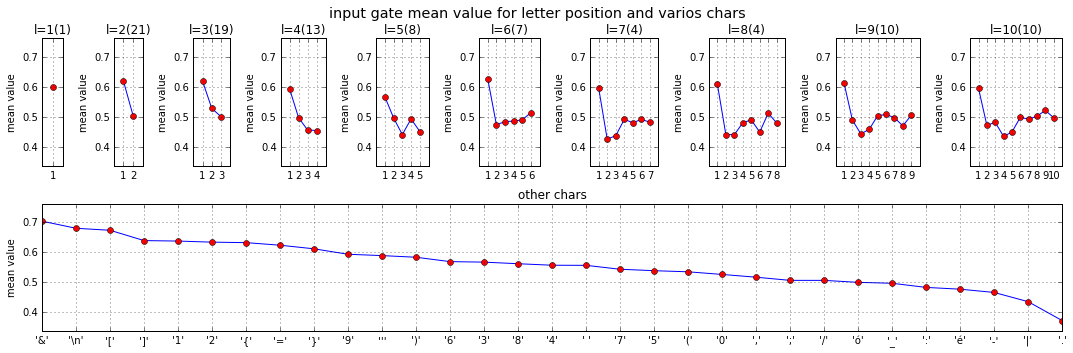

In [18]:
structure_vocabulary_plots(text_list,
                           input_list,
                           'input gate mean value for letter position and varios chars',
                           'mean value',
                           ['simple', '1', 'gates'],
                           'mean_input',
                           show=True)  


[u'9', u'0', u'8', u'7', u'5', u'4', u'6', u'&', u'=', u'3', u',', u'\n', u'/', u'}', u'2', u"'", u'[', u'1', u']', u'{', u' ', u':', u'(', u'-', u')', u'\xf3', u';', u'|', u'_', u'\xe9', u'.']


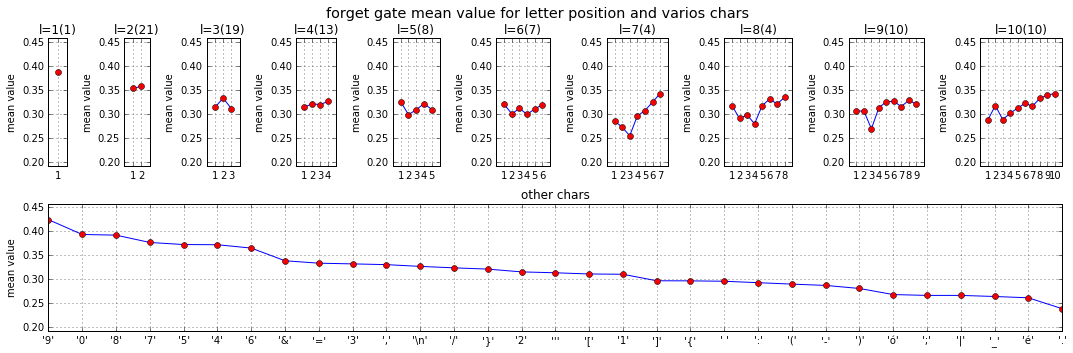

In [19]:

structure_vocabulary_plots(text_list,
                           forget_list,
                           'forget gate mean value for letter position and varios chars',
                           'mean value',
                           ['simple', '1', 'gates'],
                           'mean_forget',
                           show=True)

In [35]:

model1.simple_run(10000,              #minimum number of steps
                  1000,               #how often average loss is calculated
                  5000,               #number of steps to be performed before nex try to stop learning
                  20,                 #number times learning rate will decay
                  0.9,                #decay
                  3,                  #stop percent
                  100,                #averaging number
                  save_path='simple/1/nn16_hl500')       #path to save variables      

Number of steps = 10001     Percentage = 38.19%     Time = 113s     Leraning rate = 1.22


In [12]:
num_layers_values = [1, 2, 3]
num_nodes_values = [[32, 48, 64, 92, 128, 160, 192, 256, 384, 512],
                    [32, 48, 64, 128],
                    [32, 64, 128]]
num_unrollings_values = [10, 20, 40, 80]
batch_size_GL = 64
decay_GL = 0.9

results1_GL = list()
num_nodes = [0]

for num_nodes[0] in num_nodes_values[0]:
    print(' '*10 + "Number of nodes in 1st layer: ", num_nodes[0])
    for num_unrollings in num_unrollings_values:
        print(' '*5 + "Number of unrollings: ", num_unrollings)
        model = MODEL(batch_size_GL,
                      num_unrollings,
                      1,
                      [num_nodes[0]])
        model.simple_run(20000,              #minimum number of steps
                         1000,               #how often average loss is calculated
                         5000,               #number of steps to be performed before nex try to stop learning
                         20,                 #number times learning rate will decay
                         0.9,                #decay
                         3,                  #stop percent
                         100)            
        results1_GL.extend(model._results)
        model.destroy()
        del model
        gc.collect()
                


          Number of nodes in 1st layer:  32
     Number of unrollings:  10
Number of steps = 20001     Percentage = 44.99%     Time = 233s     Leraning rate = 1.22
     Number of unrollings:  20
Number of steps = 20001     Percentage = 45.67%     Time = 473s     Leraning rate = 1.22
     Number of unrollings:  40
Number of steps = 20001     Percentage = 44.20%     Time = 1093s     Leraning rate = 1.22
     Number of unrollings:  80
Number of steps = 20001     Percentage = 45.14%     Time = 2379s     Leraning rate = 1.22
          Number of nodes in 1st layer:  48
     Number of unrollings:  10
Number of steps = 25001     Percentage = 48.34%     Time = 301s     Leraning rate = 0.72
     Number of unrollings:  20
Number of steps = 20001     Percentage = 48.74%     Time = 509s     Leraning rate = 1.22
     Number of unrollings:  40
Number of steps = 20001     Percentage = 48.61%     Time = 1216s     Leraning rate = 1.22
     Number of unrollings:  80
Number of steps = 20001     Percentage

In [19]:
folder_name = 'simple_model'
file_name = 'simple_1.pickle'
force = True
pickle_dump = {'results1_GL': results1_GL}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling simple_model/simple_1.pickle.


In [23]:
results2_GL = list()
num_nodes = [0, 0]                

for num_nodes[0] in num_nodes_values[1]:
    print(' '*15 + "Number of nodes in 1st layer: ", num_nodes[0])
    for num_nodes[1] in num_nodes_values[1]:
        print(' '*10 + "Number of nodes in 2nd layer: ", num_nodes[1])
        for num_unrollings in num_unrollings_values:
            print(' '*5 + "Number of unrollings: ", num_unrollings)
            model = MODEL(batch_size_GL,
                          num_unrollings,
                          2,
                          [num_nodes[0], num_nodes[1]])
            model.simple_run(20000,              #minimum number of steps
                             1000,               #how often average loss is calculated
                             5000,               #number of steps to be performed before nex try to stop learning
                             20,                 #number times learning rate will decay
                             0.9,                #decay
                             3,                  #stop percent
                             100)            
            results2_GL.extend(model._results)
            model.destroy()
            del model
            gc.collect()

               Number of nodes in 1st layer:  32
          Number of nodes in 2nd layer:  32
     Number of unrollings:  10
Number of steps = 25001     Percentage = 48.78%     Time = 474s     Leraning rate = 0.72
     Number of unrollings:  20
Number of steps = 20001     Percentage = 49.38%     Time = 829s     Leraning rate = 1.22
     Number of unrollings:  40
Number of steps = 25001     Percentage = 50.26%     Time = 2439s     Leraning rate = 0.72
     Number of unrollings:  80
Number of steps = 20001     Percentage = 49.91%     Time = 4262s     Leraning rate = 1.22
          Number of nodes in 2nd layer:  48
     Number of unrollings:  10
Number of steps = 25001     Percentage = 50.42%     Time = 530s     Leraning rate = 0.72
     Number of unrollings:  20
Number of steps = 20001     Percentage = 51.01%     Time = 1012s     Leraning rate = 1.22
     Number of unrollings:  40
Number of steps = 25001     Percentage = 51.85%     Time = 2744s     Leraning rate = 0.72
     Number of unro

In [24]:
folder_name = 'simple_model'
file_name = 'simple_2.pickle'
force = True
pickle_dump = {'results2_GL': results2_GL}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling simple_model/simple_2.pickle.


In [25]:
results3_GL = list()
num_nodes = [0, 0, 0]                

for num_nodes[0] in num_nodes_values[2]:
    print(' '*20 + "Number of nodes in 1st layer: ", num_nodes[0])
    for num_nodes[1] in num_nodes_values[2]:
        print(' '*15 + "Number of nodes in 2nd layer: ", num_nodes[1])
        for num_nodes[2] in num_nodes_values[2]:
            print(' '*10 + "Number of nodes in 3rd layer: ", num_nodes[2])
            for num_unrollings in num_unrollings_values:
                print(' '*5 + "Number of unrollings: ", num_unrollings)
                model = MODEL(batch_size_GL,
                              num_unrollings,
                              3,
                              [num_nodes[0], num_nodes[1], num_nodes[2]])
                model.simple_run(20000,              #minimum number of steps
                                 1000,               #how often average loss is calculated
                                 5000,               #number of steps to be performed before nex try to stop learning
                                 20,                 #number times learning rate will decay
                                 0.9,                #decay
                                 3,                  #stop percent
                                 100)            
                results3_GL.extend(model._results)
                model.destroy()
                del model
                gc.collect()

                    Number of nodes in 1st layer:  32
               Number of nodes in 2nd layer:  32
          Number of nodes in 3rd layer:  32
     Number of unrollings:  10
Number of steps = 25001     Percentage = 49.79%     Time = 639s     Leraning rate = 0.72
     Number of unrollings:  20
Number of steps = 20001     Percentage = 50.81%     Time = 1125s     Leraning rate = 1.22
     Number of unrollings:  40
Number of steps = 25001     Percentage = 49.75%     Time = 3300s     Leraning rate = 0.72
     Number of unrollings:  80
Number of steps = 20001     Percentage = 51.28%     Time = 5480s     Leraning rate = 1.22
          Number of nodes in 3rd layer:  64
     Number of unrollings:  10
Number of steps = 25001     Percentage = 51.81%     Time = 719s     Leraning rate = 0.72
     Number of unrollings:  20
Number of steps = 20001     Percentage = 52.88%     Time = 1305s     Leraning rate = 1.22
     Number of unrollings:  40
Number of steps = 25001     Percentage = 53.87%     Ti

In [26]:
folder_name = 'simple_model'
file_name = 'simple_3.pickle'
force = True
pickle_dump = {'results3_GL': results3_GL}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling simple_model/simple_3.pickle.


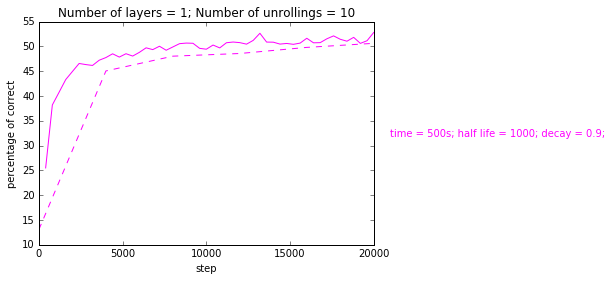

In [38]:
model1.plot([0], plot_validation=True, save=True, save_folder="first_folder_for_plot2" )

In [3]:
a = [i for i in range(1, 101)]
flags = [0]*100
skip = True
idx = 0
counter = 0
while counter < 99:
    if flags[idx] == 0 and skip:
        skip = False
        idx += 1
    elif flags[idx] == 0 and not skip:
        skip = True
        flags[idx] = 1
        idx += 1
        counter += 1
    else:
        idx += 1
    if idx == 100:
        idx = 0
print(a[flags.index(0)])

73
